In [30]:
import function as f
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
import os

In [4]:
folder_path = 'Results'
y_col = ['C_max_prev', 'C_max_now', 'C_max', 'Congestion_ratio_AVG', 'Congestion_ratio_AVG_prev', 'Congestion_ratio_AVG_now']

original_df = f.get_dfs_by_folder(folder_path, y_col, True, standard_outlier = y_col[2])

original_df = f.to_numeric(original_df, y_col[0])
original_df = f.to_numeric(original_df, y_col[1])
original_df = f.to_numeric(original_df, y_col[3])
original_df = f.to_numeric(original_df, y_col[4])
original_df = f.to_numeric(original_df, y_col[5])

for file_name, df in original_df:
    # add column
    df['Number of YT'] = int(df['Prev Truck Number'].unique()[0]) + int(df['Now Truck Number'].unique()[0])

all_alpha_df = pd.DataFrame()

# original_df에 있는 모든 파일을 합쳐 하나의 df로 만들기
for file_name, df in original_df:
    all_alpha_df = pd.concat([all_alpha_df, df], ignore_index=True)

all_alpha_df

Remove outliers by  C_max !


,Prev Truck Number,Now Truck Number,alpha_1,alpha_2,alpha_3,repeat_num,C_max_prev,C_max_now,C_max,Congestion_ratio_AVG,Congestion_ratio_AVG_prev,Congestion_ratio_AVG_now,Number of YT
0,5,5,0,0,100,1,404.816,396.952,404.816,0.036557,0.034676,0.038438,10
1,5,5,0,0,100,2,430.392,389.856,430.392,0.031613,0.046885,0.016342,10
2,5,5,0,0,100,3,395.136,403.208,403.208,0.047560,0.038560,0.056561,10
3,5,5,0,0,100,4,379.360,406.512,406.512,0.076458,0.058949,0.093967,10
4,5,5,0,0,100,5,367.512,419.168,419.168,0.023216,-0.013357,0.059789,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5753,30,30,80,10,10,56,441.536,448.848,448.848,0.286701,0.330823,0.242578,60
5754,30,30,80,10,10,57,429.856,444.728,444.728,0.332213,0.238609,0.425816,60
5755,30,30,80,10,10,58,433.640,446.616,446.616,0.371354,0.450646,0.292061,60
5756,30,30,80,10,10,59,451.176,440.272,451.176,0.260300,0.284196,0.236405,60


In [31]:
def process_subdirectories(initial_path, casename, weights, indicators):
    # Initialize the legend labels
    legend_labels = []

    # Initialize the data dictionary for each subdirectory
    data_dict = {}

    # Iterate over subdirectories
    for sub in os.listdir(os.path.join(initial_path, casename)):
        # Check if the item is a directory
        sub_path = os.path.join(initial_path, casename, sub)
        if os.path.isdir(sub_path):
            # print(f"Processing subdirectory: {sub}")

            folder_path = sub_path

            sub_data = {}

            for indicator in indicators:
                blank_df = {}

                for _ in range(len(weights[0])):
                    weight_case = str(weights[0][_]) + '_' + str(weights[1][_]) + '_' + str(weights[2][_])
                    blank_df[weight_case] = []

                # blank_df's keys and folder_path's files
                for key in blank_df.keys():
                    for file in os.listdir(folder_path):
                        if file.endswith('.csv') and key in file:
                            df = pd.read_csv(os.path.join(folder_path, file))
                            blank_df[key].append(df[indicator].iloc[0])

                # Function to remove outliers using IQR
                def remove_outliers(data):
                    Q1 = np.percentile(data, 25)
                    Q3 = np.percentile(data, 75)
                    IQR = Q3 - Q1
                    lower_bound = Q1 - 1.5 * IQR
                    upper_bound = Q3 + 1.5 * IQR
                    return [x for x in data if lower_bound <= x <= upper_bound]

                # Remove outliers from each list in blank_df
                for key, value in blank_df.items():
                    blank_df[key] = remove_outliers(value)

                # Store the data for the current indicator
                sub_data[indicator] = {key: np.mean(value) for key, value in blank_df.items()}

            # Store subdirectory data
            data_dict[sub] = sub_data

    return data_dict

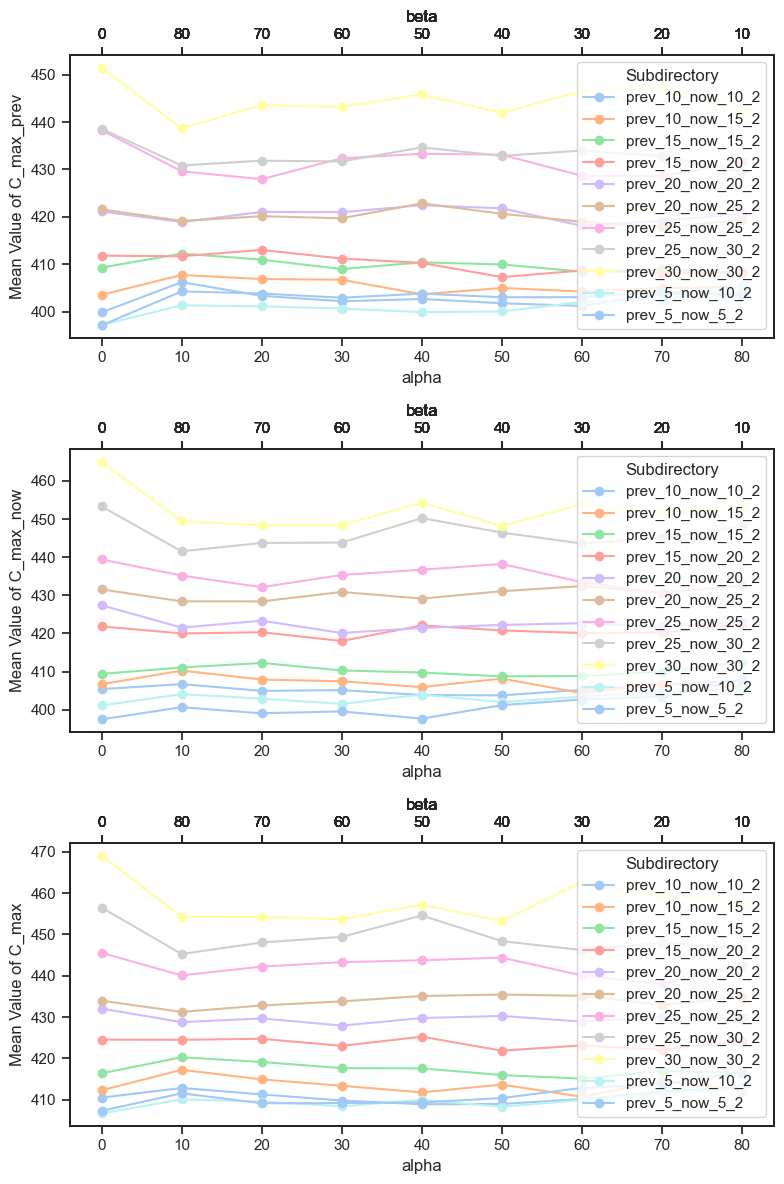

In [32]:

def plot_subdirectories(data_dict, weights, indicators):
    # Create subplots with the number of rows as the number of indicators
    fig, axs = plt.subplots(len(indicators), 1, figsize=(8, 4 * len(indicators)))

    # Iterate over each subdirectory's data
    for sub, sub_data in data_dict.items():
        # Iterate over each indicator
        for i, indicator in enumerate(indicators):
            ax = axs[i] if len(indicators) > 1 else axs  # Handle single indicator case

            # Plot data for the current subdirectory and indicator
            ax.plot(list(sub_data[indicator].keys()), list(sub_data[indicator].values()), marker='o', linestyle='-', label=sub)

            ax.set_xlabel('alpha')
            ax.set_ylabel(f'Mean Value of {indicator}')
            ax.set_xticks(range(len(sub_data[indicator])))
            ax.set_xticklabels([f'{w[0]}' for w in zip(weights[0], weights[1])])

            # Creating a second x-axis on top
            ax2 = ax.twiny()
            ax2.set_xlim(ax.get_xlim())
            ax2.set_xticks(ax.get_xticks())
            ax2.set_xticklabels([f'{w[1]}' for w in zip(weights[0], weights[1])])
            ax2.set_xlabel('beta')

            # Adding legend
            ax.legend(title='Subdirectory')

    # Display the plot
    plt.tight_layout()
    plt.show()

# Example usage
initial_path = 'C:\\Users\\USER\\workspace\\TSB\\Evaluation\\Results'
casename = 'Completiontime_Congestionratio'
weights = [[0, 10, 20, 30, 40, 50, 60, 70, 80],
           [0, 80, 70, 60, 50, 40, 30, 20, 10],
           [100, 10, 10, 10, 10, 10, 10, 10, 10]]
indicators = ['C_max_prev', 'C_max_now', 'C_max']  # Add more indicators as needed

# Process subdirectories
data_dict = process_subdirectories(initial_path, casename, weights, indicators)

# Plot subdirectories
plot_subdirectories(data_dict, weights, indicators)


In [46]:
df  = all_alpha_df.copy()

# 'Number of YT'에 따라 데이터 분리하고, 'alpha_1', 'alpha_2', 'alpha_3'의 값이 같은 행끼리 묶은 뒤, 'Congestion_ratio_AVG_prev'의 평균 계산
avg_congestion_ratio_prev_by_yt = df.groupby(['Number of YT', 'alpha_1', 'alpha_2', 'alpha_3'])['Congestion_ratio_AVG_now'].mean().reset_index()

# 결과 출력
avg_congestion_ratio_prev_by_yt

# 'Number of YT'에 따라 데이터 분리
df_by_yt = avg_congestion_ratio_prev_by_yt.groupby(['Number of YT'])

# 각 그룹에 대해 순회
for yt, group_df in df_by_yt:
    # 첫 번째 행을 기준으로 Congestion_ratio_AVG_prev의 차이 계산
    first_row = group_df.iloc[0]
    group_df['Difference_from_first'] = ((group_df['Congestion_ratio_AVG_now'] - first_row['Congestion_ratio_AVG_now']) / first_row['Congestion_ratio_AVG_now']) * 100

    # 결과 출력
    print(f"Number of YT: {yt}")
    print(group_df)

    # # 꺾은선 그래프 그리기. x축은 alpha1의 내림차순으로 정렬. y축은 Difference_from_first
    # plt.plot(group_df.sort_values(by='alpha_1', ascending=False)['alpha_1'], group_df.sort_values(by='alpha_1', ascending=False)['Difference_from_first'])
    # plt.xlabel('alpha_1')
    # plt.ylabel('Difference_from_first')
    # plt.show()






Number of YT: 10
   Number of YT  alpha_1  alpha_2  alpha_3  Congestion_ratio_AVG_now  \
0            10        0        0      100                  0.030398   
1            10       10       80       10                  0.028280   
2            10       20       70       10                  0.029146   
3            10       30       60       10                  0.035786   
4            10       40       50       10                  0.029197   
5            10       50       40       10                  0.031474   
6            10       60       30       10                  0.029100   
7            10       70       20       10                  0.029367   
8            10       80       10       10                  0.032251   

   Difference_from_first  
0               0.000000  
1              -6.966561  
2              -4.118768  
3              17.723777  
4              -3.951600  
5               3.540418  
6              -4.271644  
7              -3.391255  
8               6.0

In [6]:

grouped_by_yt = avg_congestion_ratio_prev_by_yt.groupby(['Number of YT'])

# 새로운 데이터프레임을 생성하여 결과 저장
result_df = pd.DataFrame()

# 각 그룹에 대해 순회
for yt, group_df in grouped_by_yt:
    # 첫 번째 행을 기준으로 Congestion_ratio_AVG_prev의 차이 계산
    first_row = group_df.iloc[0]
    group_df['Difference_from_first'] = ((group_df['Congestion_ratio_AVG_now'] - first_row['Congestion_ratio_AVG_now']) / first_row['Congestion_ratio_AVG_now']) * 100

    # 결과를 새로운 데이터프레임에 추가
    result_df = pd.concat([result_df, group_df[['Number of YT', 'alpha_1', 'alpha_2', 'alpha_3', 'Congestion_ratio_AVG_now', 'Difference_from_first']]])

# 결과를 CSV 파일로 저장
result_df.to_csv('result.csv', index=False)

print("Result saved to 'result.csv'")


Result saved to 'result.csv'


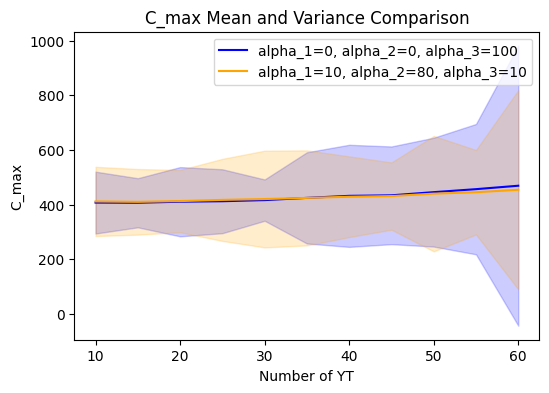

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = all_alpha_df.copy()

# 필요한 데이터 추출
alpha_1_data = df[(df['alpha_1'] == 0) & (df['alpha_2'] == 0) & (df['alpha_3'] == 100)]
alpha_2_data = df[(df['alpha_1'] == 10) & (df['alpha_2'] == 80) & (df['alpha_3'] == 10)]

# Number of YT별 C_max의 평균값 계산
mean_alpha_1 = alpha_1_data.groupby('Number of YT')['C_max'].mean()
mean_alpha_2 = alpha_2_data.groupby('Number of YT')['C_max'].mean()

# Number of YT별 C_max의 분산 계산
var_alpha_1 = alpha_1_data.groupby('Number of YT')['C_max'].var()
var_alpha_2 = alpha_2_data.groupby('Number of YT')['C_max'].var()

# 그래프 그리기
plt.figure(figsize=(6, 4))

# 평균값에 대한 라인 플롯
sns.lineplot(x=mean_alpha_1.index, y=mean_alpha_1, label='alpha_1=0, alpha_2=0, alpha_3=100', color='blue')
sns.lineplot(x=mean_alpha_2.index, y=mean_alpha_2, label='alpha_1=10, alpha_2=80, alpha_3=10', color='orange')

# 분산에 대한 그림자 표현
plt.fill_between(mean_alpha_1.index, mean_alpha_1 - var_alpha_1, mean_alpha_1 + var_alpha_1, color='blue', alpha=0.2)
plt.fill_between(mean_alpha_2.index, mean_alpha_2 - var_alpha_2, mean_alpha_2 + var_alpha_2, color='orange', alpha=0.2)

# 그래프 제목 및 레이블 설정
plt.title('C_max Mean and Variance Comparison')
plt.xlabel('Number of YT')
plt.ylabel('C_max')

# 범례 추가
plt.legend()

# 그래프 표시
plt.show()

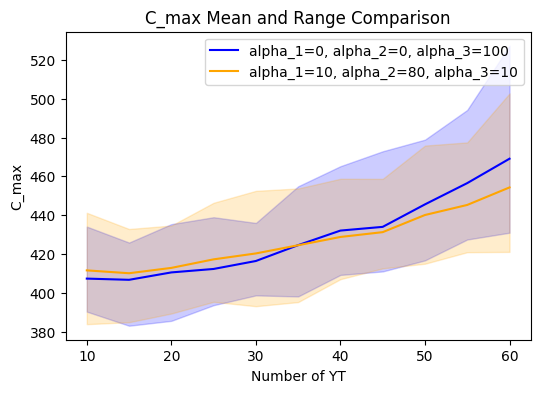

In [8]:
# 필요한 데이터 추출
alpha_1_data = df[(df['alpha_1'] == 0) & (df['alpha_2'] == 0) & (df['alpha_3'] == 100)]
alpha_2_data = df[(df['alpha_1'] == 10) & (df['alpha_2'] == 80) & (df['alpha_3'] == 10)]

# Number of YT별 C_max의 평균값 계산
mean_alpha_1 = alpha_1_data.groupby('Number of YT')['C_max'].mean()
mean_alpha_2 = alpha_2_data.groupby('Number of YT')['C_max'].mean()

# Number of YT별 C_max의 최대, 최소값 계산
min_alpha_1 = alpha_1_data.groupby('Number of YT')['C_max'].min()
max_alpha_1 = alpha_1_data.groupby('Number of YT')['C_max'].max()

min_alpha_2 = alpha_2_data.groupby('Number of YT')['C_max'].min()
max_alpha_2 = alpha_2_data.groupby('Number of YT')['C_max'].max()

# 그래프 그리기
plt.figure(figsize=(6, 4))

# 평균값에 대한 라인 플롯
sns.lineplot(x=mean_alpha_1.index, y=mean_alpha_1, label='alpha_1=0, alpha_2=0, alpha_3=100', color='blue')
sns.lineplot(x=mean_alpha_2.index, y=mean_alpha_2, label='alpha_1=10, alpha_2=80, alpha_3=10', color='orange')

# 실제 값의 범위에 대한 그림자 표현
plt.fill_between(mean_alpha_1.index, min_alpha_1, max_alpha_1, color='blue', alpha=0.2)
plt.fill_between(mean_alpha_2.index, min_alpha_2, max_alpha_2, color='orange', alpha=0.2)

# 그래프 제목 및 레이블 설정
plt.title('C_max Mean and Range Comparison')
plt.xlabel('Number of YT')
plt.ylabel('C_max')

# 범례 추가
plt.legend()

# 그래프 표시
plt.show()

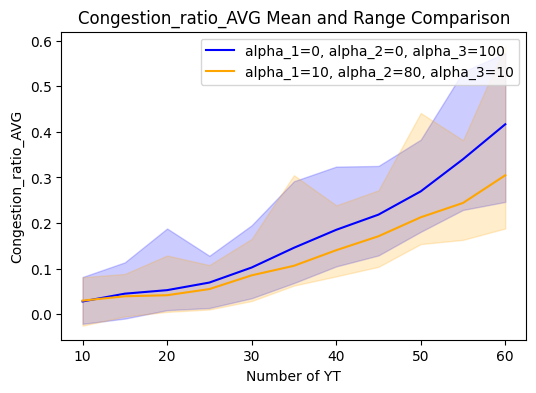

In [9]:
# 필요한 데이터 추출
alpha_1_data = df[(df['alpha_1'] == 0) & (df['alpha_2'] == 0) & (df['alpha_3'] == 100)]
alpha_2_data = df[(df['alpha_1'] == 10) & (df['alpha_2'] == 80) & (df['alpha_3'] == 10)]

# Number of YT별 Congestion_ratio_AVG의 평균값 계산
mean_alpha_1 = alpha_1_data.groupby('Number of YT')['Congestion_ratio_AVG'].mean()
mean_alpha_2 = alpha_2_data.groupby('Number of YT')['Congestion_ratio_AVG'].mean()

# Congestion_ratio_AVG의 최대, 최소값 계산
min_alpha_1 = alpha_1_data.groupby('Number of YT')['Congestion_ratio_AVG'].min()
max_alpha_1 = alpha_1_data.groupby('Number of YT')['Congestion_ratio_AVG'].max()

min_alpha_2 = alpha_2_data.groupby('Number of YT')['Congestion_ratio_AVG'].min()
max_alpha_2 = alpha_2_data.groupby('Number of YT')['Congestion_ratio_AVG'].max()

# 그래프 그리기
plt.figure(figsize=(6, 4))

# 평균값에 대한 라인 플롯
sns.lineplot(x=mean_alpha_1.index, y=mean_alpha_1, label='alpha_1=0, alpha_2=0, alpha_3=100', color='blue')
sns.lineplot(x=mean_alpha_2.index, y=mean_alpha_2, label='alpha_1=10, alpha_2=80, alpha_3=10', color='orange')

# 실제 값의 범위에 대한 그림자 표현
plt.fill_between(mean_alpha_1.index, min_alpha_1, max_alpha_1, color='blue', alpha=0.2)
plt.fill_between(mean_alpha_2.index, min_alpha_2, max_alpha_2, color='orange', alpha=0.2)

# 그래프 제목 및 레이블 설정
plt.title('Congestion_ratio_AVG Mean and Range Comparison')
plt.xlabel('Number of YT')
plt.ylabel('Congestion_ratio_AVG')

# 범례 추가
plt.legend()

# 그래프 표시
plt.show()

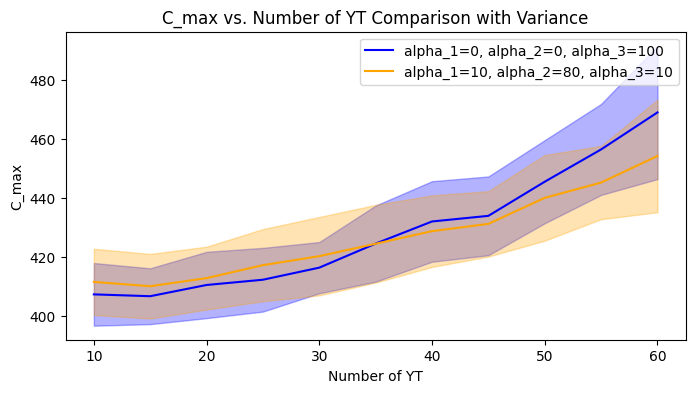

In [10]:

# alpha_1이 0, alpha_2가 0, alpha_3이 100인 행 추출
filtered_data_1 = df[(df['alpha_1'] == 0) & (df['alpha_2'] == 0) & (df['alpha_3'] == 100)]

# alpha_1이 10, alpha_2가 80, alpha_3이 10인 행 추출
filtered_data_2 = df[(df['alpha_1'] == 10) & (df['alpha_2'] == 80) & (df['alpha_3'] == 10)]

# 각각의 데이터에 대해 Number of YT 별로 C_max의 평균 및 분산 계산
grouped_data_1 = filtered_data_1.groupby('Number of YT')['C_max'].agg(['mean', 'std']).reset_index()
grouped_data_2 = filtered_data_2.groupby('Number of YT')['C_max'].agg(['mean', 'std']).reset_index()

# 그래프 그리기
plt.figure(figsize=(8, 4))

# 꺾은선 그래프 및 그림자 처리
plt.plot(grouped_data_1['Number of YT'], grouped_data_1['mean'], label='alpha_1=0, alpha_2=0, alpha_3=100', color='blue')
plt.fill_between(
    grouped_data_1['Number of YT'],
    grouped_data_1['mean'] - grouped_data_1['std'],
    grouped_data_1['mean'] + grouped_data_1['std'],
    color='blue',
    alpha=0.3
)

plt.plot(grouped_data_2['Number of YT'], grouped_data_2['mean'], label='alpha_1=10, alpha_2=80, alpha_3=10', color='orange')
plt.fill_between(
    grouped_data_2['Number of YT'],
    grouped_data_2['mean'] - grouped_data_2['std'],
    grouped_data_2['mean'] + grouped_data_2['std'],
    color='orange',
    alpha=0.3
)

# 그래프 제목 및 레이블 설정
plt.title('C_max vs. Number of YT Comparison with Variance')
plt.xlabel('Number of YT')
plt.ylabel('C_max')

# 범례 추가
plt.legend()

# 그래프 표시
plt.show()


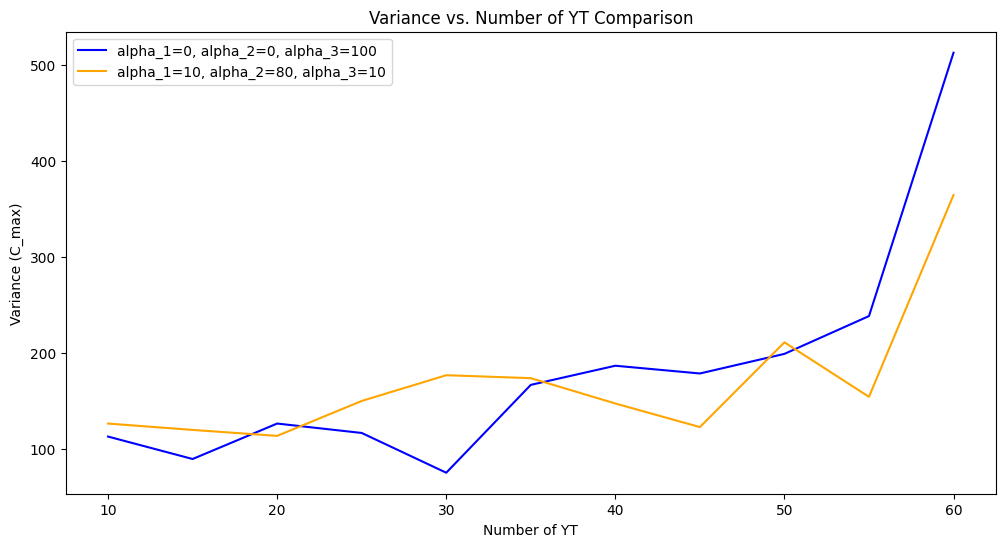

In [11]:
# 두 데이터셋에 대해 Number of YT에 따른 분산 계산
variance_data_1 = filtered_data_1.groupby('Number of YT')['C_max'].var().reset_index()
variance_data_2 = filtered_data_2.groupby('Number of YT')['C_max'].var().reset_index()

# 그래프 그리기
plt.figure(figsize=(12, 6))

plt.plot(variance_data_1['Number of YT'], variance_data_1['C_max'], label='alpha_1=0, alpha_2=0, alpha_3=100', color='blue')
plt.plot(variance_data_2['Number of YT'], variance_data_2['C_max'], label='alpha_1=10, alpha_2=80, alpha_3=10', color='orange')

# 그래프 제목 및 레이블 설정
plt.title('Variance vs. Number of YT Comparison')
plt.xlabel('Number of YT')
plt.ylabel('Variance (C_max)')

# 범례 추가
plt.legend()

# 그래프 표시
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


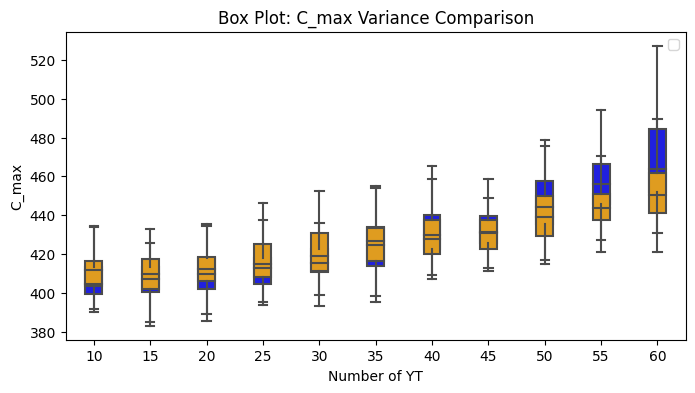

In [12]:
# 그래프 그리기
plt.figure(figsize=(8, 4))

sns.boxplot(x='Number of YT', y='C_max', data=filtered_data_1, color='blue', width=0.3,dodge=True, showfliers=False)
sns.boxplot(x='Number of YT', y='C_max', data=filtered_data_2, color='orange', width=0.3,dodge=True ,showfliers=False)

# 그래프 제목 및 레이블 설정
plt.title('Box Plot: C_max Variance Comparison')
plt.xlabel('Number of YT')
plt.ylabel('C_max')

# 범례 추가
plt.legend()

# 그래프 표시
plt.show()

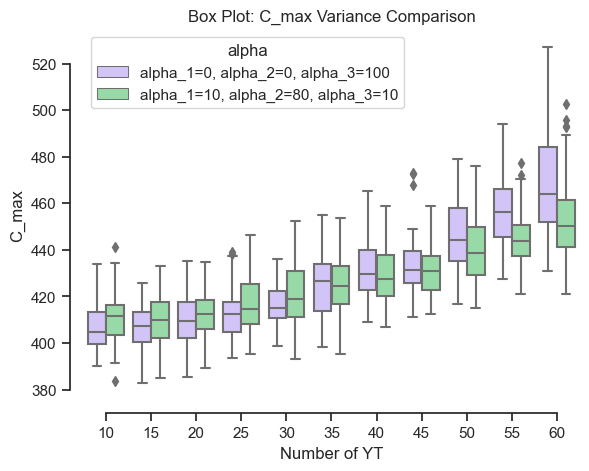

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# 데이터프레임이 tips 대신 filtered_data_1과 filtered_data_2를 사용
sns.set_theme(style="ticks", palette="pastel")

# Combine the two datasets for visualization
combined_data = pd.concat([filtered_data_1.assign(alpha='alpha_1=0, alpha_2=0, alpha_3=100'), 
                           filtered_data_2.assign(alpha='alpha_1=10, alpha_2=80, alpha_3=10')])

# Draw a nested boxplot to show C_max by Number of YT and alpha
sns.boxplot(x="Number of YT", y="C_max",
            hue="alpha", palette=["m", "g"],
            data=combined_data)
sns.despine(offset=10, trim=True)

# Set the title and labels
plt.title('Box Plot: C_max Variance Comparison')
plt.xlabel('Number of YT')
plt.ylabel('C_max')

# Show the plot
plt.show()


#
alpha = [[0, 10, 20, 30, 40, 50, 60, 70, 80],
         [0, 80, 70, 60, 50, 40, 30, 20, 10],
         [100, 10, 10, 10, 10, 10, 10, 10, 10]]


c:\Users\USER\anaconda3\envs\hyeooi\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\Users\USER\anaconda3\envs\hyeooi\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\Users\USER\anaconda3\envs\hyeooi\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

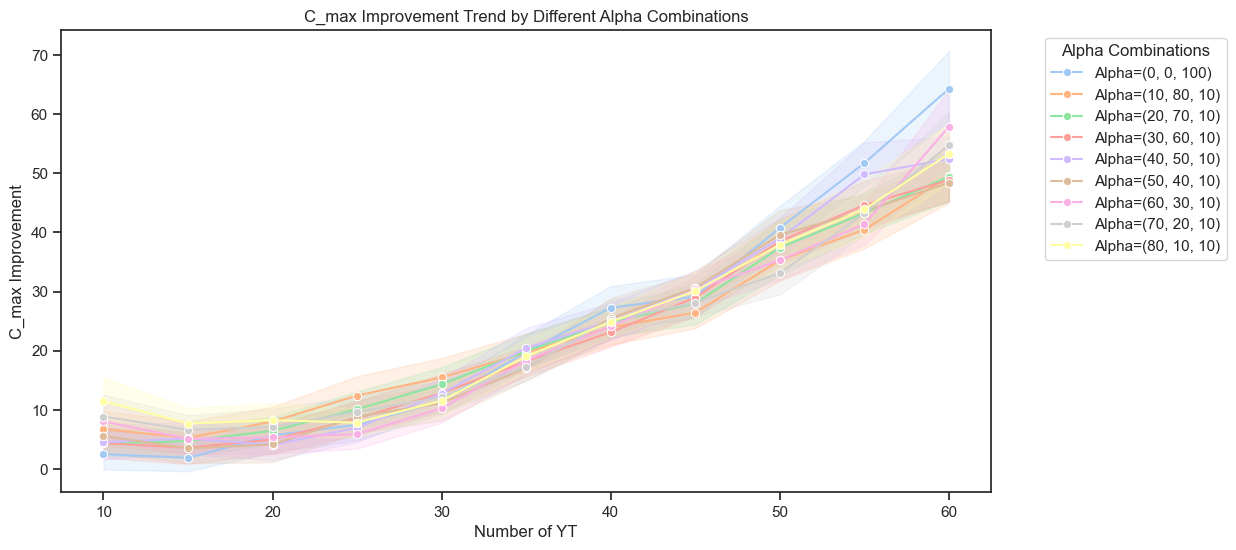

In [14]:
# 주어진 alpha값에 따라 데이터 필터링
alpha_values = [[0, 10, 20, 30, 40, 50, 60, 70, 80],
                [0, 80, 70, 60, 50, 40, 30, 20, 10],
                [100, 10, 10, 10, 10, 10, 10, 10, 10]]

# 그래프 그리기
plt.figure(figsize=(12, 6))

baseline_alpha = [0, 0, 100]  # Baseline alpha values

for alpha_combination in zip(*alpha_values):
    filtered_data = df[(df['alpha_1'] == alpha_combination[0]) & 
                       (df['alpha_2'] == alpha_combination[1]) & 
                       (df['alpha_3'] == alpha_combination[2])]
    
    baseline_data = df[(df['alpha_1'] == baseline_alpha[0]) & 
                       (df['alpha_2'] == baseline_alpha[1]) & 
                       (df['alpha_3'] == baseline_alpha[2])]
    
    # Calculate the performance improvement
    filtered_data['Performance Improvement'] = filtered_data['C_max'] - baseline_data['C_max'].values[0]
    
    sns.lineplot(x='Number of YT', y='Performance Improvement', label=f'Alpha={alpha_combination}', data=filtered_data, marker='o')

# 그래프 제목 및 레이블 설정
plt.title('C_max Improvement Trend by Different Alpha Combinations')
plt.xlabel('Number of YT')
plt.ylabel('C_max Improvement')

# 범례 추가
plt.legend(title='Alpha Combinations', bbox_to_anchor=(1.05, 1), loc='upper left')

# 그래프 표시
plt.show()